In [ ]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
from parse_density_files import CUBE
import alchemy_tools2 as at

import glob
import numpy as np
import os

In [ ]:
cube_paths = glob.glob('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_003700/shift_molecule/shift_z*')
cube_paths.sort()
# cube_paths

In [ ]:
cube_paths

### calculate alchemical potentials

In [ ]:
for path in cube_paths:
    cube = CUBE(path + '/DENSITY.cube')
    density = cube.data_scaled
    meshgrid = cube.get_grid()
    h_mat = cube.get_hmatrix()
    nuclei = cube.atoms
    ae_rep, ae, alch_pots = at.calculate_atomic_energies(density, nuclei, meshgrid, h_mat)
    
    save = np.array([nuclei[:,0], nuclei[:,1], nuclei[:,2], nuclei[:,3], alch_pots]).T
    header = 'charge\t x_coord\t y_coord\t z_coord\t alchemical_potential'
    save_dir = os.path.join(path, 'alchpots.txt')
    np.savetxt(save_dir, save, delimiter='\t', header = header)

In [ ]:
# calculate potential for no shift 
path_no_shift = '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_003700/shift_molecule/shift_z0'
cube_no_shift = CUBE('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_003700/cube-files/ve_38.cube')
density = cube_no_shift.data_scaled
meshgrid = cube_no_shift.get_grid()
h_mat = cube_no_shift.get_hmatrix()
nuclei = cube_no_shift.atoms
ae_rep, ae, alch_pots = at.calculate_atomic_energies(density, nuclei, meshgrid, h_mat)

save = np.array([nuclei[:,0], nuclei[:,1], nuclei[:,2], nuclei[:,3], alch_pots]).T
header = 'charge\t x_coord\t y_coord\t z_coord\t alchemical_potential'
save_dir = os.path.join(path_no_shift, 'alchpots.txt')
np.savetxt(save_dir, save, delimiter='\t', header = header)

### plot results

In [1]:
import glob
import numpy as np
from matplotlib import pyplot as plt

def get_atom(alch_data, i_at):
    alchpots_i = []
    for d in alch_data:
        alchpots_i.append(d[i_at,-1])
    return(np.array(alchpots_i))

In [2]:
# cube_paths_x = glob.glob('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/shift_molecule/shift_x*')
# cube_paths_x.sort()
# cube_paths_y = glob.glob('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/shift_molecule/shift_y*')
# cube_paths_y.sort()
cube_paths_z = glob.glob('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_003700/shift_molecule/shift_z*')
cube_paths_z.sort()

# for c in [cube_paths_x, cube_paths_y, cube_paths_z]:
#     c.insert(0, '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/shift_molecule/shift_0')

In [4]:
# alch_data_x = []
# for p in cube_paths_x:
#     alch_data_x.append(np.loadtxt(p+'/alchpots.txt'))
    
# alch_data_y = []
# for p in cube_paths_y:
#     alch_data_y.append(np.loadtxt(p+'/alchpots.txt'))
    
alch_data_z = []
for p in cube_paths_z:
    alch_data_z.append(np.loadtxt(p+'/alchpots.txt'))

In [5]:
d_gpt = 0.1142858729882622
shifts = np.linspace(0, d_gpt, 10)

#### Shift along x

In [ ]:
# mean and std per element of energy difference between max and min value as function of gpt 
dE = {1.0:[], 6.0:[], 7.0:[], 8.0:[]}
for i in range(len(alch_data_x[0])):
    data_atom = get_atom(alch_data_x, i)
    Z = alch_data_x[0][i,0]
    diff = np.abs(np.amax(data_atom) - np.amin(data_atom))
    dE[Z].append(diff)

dE_stat = {1.0:[], 6.0:[], 7.0:[], 8.0:[]}
for k in dE.keys():
    dE_Z = np.array(dE[k])
    dE_stat[k].extend([dE_Z.mean(), dE_Z.std()])

In [ ]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [12, 10]
fig, ax = plt.subplots(2,2)
import itertools as it
for ax_i in it.product((0,1), (0,1)):
    ax[ax_i].ticklabel_format(style ='sci', scilimits=(0,0), axis='y')
    ax[ax_i].set_ylabel(r'$\Delta E(\Delta_x)$ (Ha)')
    for i in range(len(alch_data_x[0])):
        data_atom = get_atom(alch_data_x, i)
        Z = alch_data_x[0][i,0]
        data_atom = data_atom - np.amin(data_atom)
        
        if Z == 1.0 and ax_i == (0,0):
            ax[ax_i].set_title(r'H = ' + str(np.format_float_scientific(dE_stat[Z][0], 1)) + r'$\pm$' + str(np.format_float_scientific(dE_stat[Z][1], 1)) + ' (Ha)', fontsize=16)
            ax[ax_i].plot(shifts, data_atom, '-o', label = f'Z = {Z}', color = 'tab:blue')
            print(np.amax(data_atom))
        elif Z == 6.0 and ax_i == (0,1):
            ax[ax_i].set_title(r'C = ' + str(np.format_float_scientific(dE_stat[Z][0], 1)) + r'$\pm$' + str(np.format_float_scientific(dE_stat[Z][1], 1))+ ' (Ha)', fontsize=16)
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:orange')
        elif Z == 7.0and ax_i == (1,0):
            ax[ax_i].set_xlabel(r'$\Delta_x$ (Ang)')
            ax[ax_i].set_title(r'N = ' + str(np.format_float_scientific(dE_stat[Z][0], 1))+ ' (Ha)', fontsize=16 )
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:green')
        elif Z == 8.0 and ax_i == (1,1):
            ax[ax_i].set_xlabel(r'$\Delta_x$ (Ang)')
            ax[ax_i].set_title(r'O = ' + str(np.format_float_scientific(dE_stat[Z][0], 1)) + r'$\pm$' + str(np.format_float_scientific(dE_stat[Z][1], 1))+ ' (Ha)', fontsize=16)
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:red')
        
# ax[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('/home/misa/projects/Atomic-Energies/figures/r_integration/dE_pos_rel2gpt.png', bbox_inches='tight')

- H depends strongly on position of atoms relative to grid points (max difference on average 15 mHa)
- weaker influence on C (0.2 mHa), N(0.22 mH) and O (3.3 mHa)
- similar results for other axes
Explanation for trend: position of nucleus relative to grid size important if density changes fast around nucleus
- Hydrogens are in periphery of molecule where the density decays stronger
- carbons are in center of molecule where density varies less
- also for heavy atoms density might decay slower because they attract more density due to the higher nuclear charge (but does this influence the decay rate?)


- the ML error learning everything together = 24 mH (N=4096) and learning only H is in similar range 12 mH (N = 2048)
- as well for oxygen ML error = 6 mHa (N=512)
- but for carbon (ML error = 5 mHa, N=2048) and nitrogen (ML error = 8 mHa, N =512) more than one order of magnitude higher than maximum error due to finite grid size
- Maybe coincidence that for this molecule grid size error so low compared to ML error for C and N?

In [ ]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots(1,1)
for i in range(len(alch_data_x[0])):
    data_atom = get_atom(alch_data_x, i)
    Z = alch_data_x[0][i,0]
    data_atom = data_atom - np.amin(data_atom)
    if Z == 1.0:
        ax.plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:blue')
    elif Z == 6.0:
        ax.plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:orange')
    elif Z == 7.0:
        ax.plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:green')
    elif Z == 8.0:
        ax.plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:red')
        
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel(r'$\Delta_x$ (Ang)')
ax.set_ylabel(r'$\Delta E$ (Ha)')

In [ ]:
# compare mean amplitude with error for learning of alchemical potentials
# explain difference for elements

#### Shift along y

In [ ]:
# mean and std per element of energy difference between max and min value as function of gpt 
dE = {1.0:[], 6.0:[], 7.0:[], 8.0:[]}
for i in range(len(alch_data_y[0])):
    data_atom = get_atom(alch_data_y, i)
    Z = alch_data_y[0][i,0]
    diff = np.abs(np.amax(data_atom) - np.amin(data_atom))
    dE[Z].append(diff)

dE_stat = {1.0:[], 6.0:[], 7.0:[], 8.0:[]}
for k in dE.keys():
    dE_Z = np.array(dE[k])
    dE_stat[k].extend([dE_Z.mean(), dE_Z.std()])
    
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots(2,2)
import itertools as it
for ax_i in it.product((0,1), (0,1)):
    ax[ax_i].ticklabel_format(style ='sci', scilimits=(0,0), axis='y')
    ax[ax_i].set_xlabel(r'$\Delta_x$ (Ang)')
    ax[ax_i].set_ylabel(r'$\Delta E(\Delta_x)$ (Ha)')
    for i in range(len(alch_data_y[0])):
        data_atom = get_atom(alch_data_y, i)
        Z = alch_data_y[0][i,0]
        data_atom = data_atom - np.amin(data_atom)
        if Z == 1.0 and ax_i == (0,0):
            ax[ax_i].set_title(r'H = ' + str(np.format_float_scientific(dE_stat[Z][0], 1)) + r'$\pm$' + str(np.format_float_scientific(dE_stat[Z][1], 1)) + ' (Ha)')
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:blue')
        elif Z == 6.0 and ax_i == (0,1):
            ax[ax_i].set_title(r'C = ' + str(np.format_float_scientific(dE_stat[Z][0], 1)) + r'$\pm$' + str(np.format_float_scientific(dE_stat[Z][1], 1))+ ' (Ha)')
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:orange')
        elif Z == 7.0and ax_i == (1,0):
            ax[ax_i].set_title(r'N = ' + str(np.format_float_scientific(dE_stat[Z][0], 1))+ ' (Ha)' )
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:green')
        elif Z == 8.0 and ax_i == (1,1):
            ax[ax_i].set_title(r'O = ' + str(np.format_float_scientific(dE_stat[Z][0], 1)) + r'$\pm$' + str(np.format_float_scientific(dE_stat[Z][1], 1))+ ' (Ha)')
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:red')
        
# ax[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


#### Shift along z

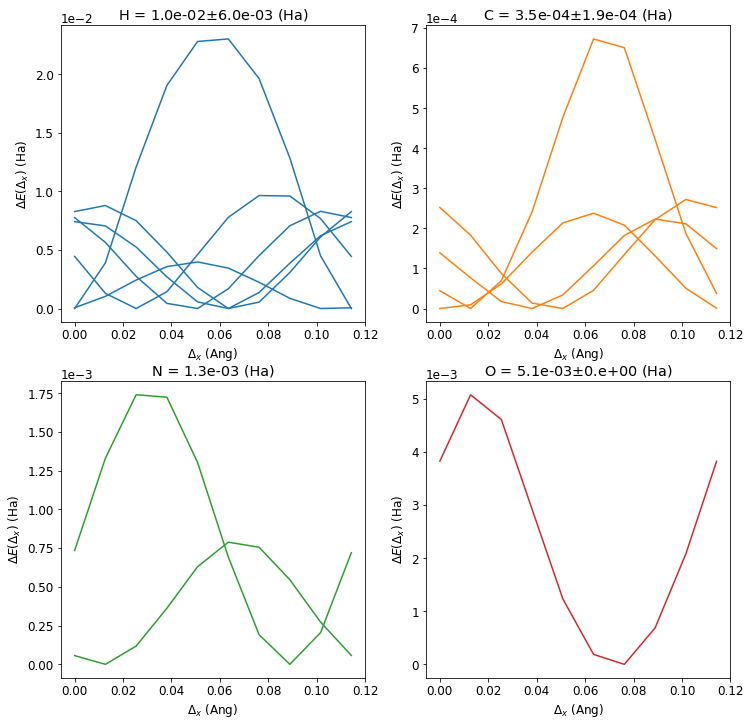

In [6]:
# mean and std per element of energy difference between max and min value as function of gpt 
dE = {1.0:[], 6.0:[], 7.0:[], 8.0:[]}
for i in range(len(alch_data_z[0])):
    data_atom = get_atom(alch_data_z, i)
    Z = alch_data_z[0][i,0]
    diff = np.abs(np.amax(data_atom) - np.amin(data_atom))
    dE[Z].append(diff)

dE_stat = {1.0:[], 6.0:[], 7.0:[], 8.0:[]}
for k in dE.keys():
    dE_Z = np.array(dE[k])
    dE_stat[k].extend([dE_Z.mean(), dE_Z.std()])
    
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots(2,2)
import itertools as it
for ax_i in it.product((0,1), (0,1)):
    ax[ax_i].ticklabel_format(style ='sci', scilimits=(0,0), axis='y')
    ax[ax_i].set_xlabel(r'$\Delta_x$ (Ang)')
    ax[ax_i].set_ylabel(r'$\Delta E(\Delta_x)$ (Ha)')
    for i in range(len(alch_data_z[0])):
        data_atom = get_atom(alch_data_z, i)
        Z = alch_data_z[0][i,0]
        data_atom = data_atom - np.amin(data_atom)
        if Z == 1.0 and ax_i == (0,0):
            ax[ax_i].set_title(r'H = ' + str(np.format_float_scientific(dE_stat[Z][0], 1)) + r'$\pm$' + str(np.format_float_scientific(dE_stat[Z][1], 1)) + ' (Ha)')
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:blue')
        elif Z == 6.0 and ax_i == (0,1):
            ax[ax_i].set_title(r'C = ' + str(np.format_float_scientific(dE_stat[Z][0], 1)) + r'$\pm$' + str(np.format_float_scientific(dE_stat[Z][1], 1))+ ' (Ha)')
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:orange')
        elif Z == 7.0and ax_i == (1,0):
            ax[ax_i].set_title(r'N = ' + str(np.format_float_scientific(dE_stat[Z][0], 1))+ ' (Ha)' )
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:green')
        elif Z == 8.0 and ax_i == (1,1):
            ax[ax_i].set_title(r'O = ' + str(np.format_float_scientific(dE_stat[Z][0], 1)) + r'$\pm$' + str(np.format_float_scientific(dE_stat[Z][1], 1))+ ' (Ha)')
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:red')
        
# ax[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


#### integration with simpsons rule

In [ ]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
from parse_density_files import CUBE
import alchemy_tools2 as at

import glob
import numpy as np
import os

In [ ]:
cube_paths = glob.glob('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/shift_molecule/shift_*')
cube_paths.sort()
# cube_paths

In [ ]:
for path in cube_paths:
    cube = CUBE(path + '/DENSITY.cube')
    density = cube.data
    meshgrid = cube.get_grid()
    h_mat = cube.get_hmatrix()
    nuclei = cube.atoms
    ae_rep, ae, alch_pots = at.calculate_atomic_energies(density, nuclei, meshgrid, h_mat, 'simps')
    
    save = np.array([nuclei[:,0], nuclei[:,1], nuclei[:,2], nuclei[:,3], alch_pots]).T
    header = 'charge\t x_coord\t y_coord\t z_coord\t alchemical_potential'
    save_dir = os.path.join(path, 'alchpots_simps.txt')
    np.savetxt(save_dir, save, delimiter='\t', header = header)

In [ ]:
# cube = CUBE('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/cube-files/ve_38.cube')
# density = cube.data
# meshgrid = cube.get_grid()
# h_mat = cube.get_hmatrix()
# nuclei = cube.atoms
# ae_rep, ae, alch_pots = at.calculate_atomic_energies(density, nuclei, meshgrid, h_mat, 'simps')

# save = np.array([nuclei[:,0], nuclei[:,1], nuclei[:,2], nuclei[:,3], alch_pots]).T
# header = 'charge\t x_coord\t y_coord\t z_coord\t alchemical_potential'
# save_dir = os.path.join('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/shift_molecule/shift_0', 'alchpots_simps.txt')
# np.savetxt(save_dir, save, delimiter='\t', header = header)

In [ ]:
import glob
import numpy as np
from matplotlib import pyplot as plt

def get_atom(alch_data, i_at):
    alchpots_i = []
    for d in alch_data:
        alchpots_i.append(d[i_at,-1])
    return(np.array(alchpots_i))

In [ ]:
cube_paths_x = glob.glob('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/shift_molecule/shift_x*')
cube_paths_x.sort()
cube_paths_x.insert(0, '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/shift_molecule/shift_0')

In [ ]:
alch_data_x = []
for p in cube_paths_x:
    alch_data_x.append(np.loadtxt(p+'/alchpots_simps.txt'))

In [ ]:
atom8 = []
for i in range(len(alch_data_x)):
    atom8.append(alch_data_x[i][8][-1])
atom8 = np.array(atom8)
atom8 = atom8 - np.amin(atom8)

In [ ]:
plt.plot(shifts, atom8)

In [ ]:
d_gpt = 0.1142858729882622
shifts = np.linspace(0, d_gpt, 10)

In [ ]:
# mean and std per element of energy difference between max and min value as function of gpt 
dE = {1.0:[], 6.0:[], 7.0:[], 8.0:[]}
for i in range(len(alch_data_x[0])):
    data_atom = get_atom(alch_data_x, i)
    Z = alch_data_x[0][i,0]
    diff = np.abs(np.amax(data_atom) - np.amin(data_atom))
    dE[Z].append(diff)

dE_stat = {1.0:[], 6.0:[], 7.0:[], 8.0:[]}
for k in dE.keys():
    dE_Z = np.array(dE[k])
    dE_stat[k].extend([dE_Z.mean(), dE_Z.std()])

In [ ]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [12, 10]
fig, ax = plt.subplots(2,2)
import itertools as it
for ax_i in it.product((0,1), (0,1)):
    ax[ax_i].ticklabel_format(style ='sci', scilimits=(0,0), axis='y')
    ax[ax_i].set_ylabel(r'$\Delta E(\Delta_x)$ (Ha)')
    for i in range(len(alch_data_x[0])):
        data_atom = get_atom(alch_data_x, i)
        Z = alch_data_x[0][i,0]
        data_atom = data_atom - np.amin(data_atom)
        
        if Z == 1.0 and ax_i == (0,0):
            ax[ax_i].set_title(r'H = ' + str(np.format_float_scientific(dE_stat[Z][0], 1)) + r'$\pm$' + str(np.format_float_scientific(dE_stat[Z][1], 1)) + ' (Ha)', fontsize=16)
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:blue')
            print(np.amax(data_atom))
        elif Z == 6.0 and ax_i == (0,1):
            ax[ax_i].set_title(r'C = ' + str(np.format_float_scientific(dE_stat[Z][0], 1)) + r'$\pm$' + str(np.format_float_scientific(dE_stat[Z][1], 1))+ ' (Ha)', fontsize=16)
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:orange')
        elif Z == 7.0and ax_i == (1,0):
            ax[ax_i].set_xlabel(r'$\Delta_x$ (Ang)')
            ax[ax_i].set_title(r'N = ' + str(np.format_float_scientific(dE_stat[Z][0], 1))+ ' (Ha)', fontsize=16 )
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:green')
        elif Z == 8.0 and ax_i == (1,1):
            ax[ax_i].set_xlabel(r'$\Delta_x$ (Ang)')
            ax[ax_i].set_title(r'O = ' + str(np.format_float_scientific(dE_stat[Z][0], 1)) + r'$\pm$' + str(np.format_float_scientific(dE_stat[Z][1], 1))+ ' (Ha)', fontsize=16)
            ax[ax_i].plot(shifts, data_atom, label = f'Z = {Z}', color = 'tab:red')
        
# ax[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/r_integration/dE_pos_rel2gpt_simps.png', bbox_inches='tight')

In [ ]:
only have a period?